# Ensembles

Test the result of using several ANN for the same prediction task


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split #pip install -U scikit-learn
from sklearn.preprocessing import MinMaxScaler

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

import time
import operator

Using TensorFlow backend.


In [2]:
datos = pd.read_csv('datos.csv')
#datos = datos.sample(frac=1)

x_data = datos.drop(labels=['PTO_X', 'PTO_Y'], axis=1)
y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)

mejores = {}
macs_old = ['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9']
for i in macs_old:
    count = 0
    for j in x_data[i]:
        if(j == -99):
            count += 1
    mejores[i] = count
    #print(i, " --> ", count)
    
sorted(mejores.items(), key=operator.itemgetter(1))
    
#--> Probar con los que menos -99 tienen: WI0, WI1, WI3, WI4, WI5, WI7

[('WI0', 71),
 ('WI7', 190),
 ('WI1', 284),
 ('WI3', 285),
 ('WI5', 293),
 ('WI4', 294),
 ('WI6', 310),
 ('WI2', 330),
 ('WI9', 360),
 ('WI8', 1281)]

In [3]:
import winsound
def beep():
    duration = 500  # millisecond
    freq = 900  # Hz
    winsound.Beep(freq, duration)
    winsound.Beep(freq, duration)
    winsound.Beep(freq, 2*duration)

In [4]:
def calcError(real, pred):
    error = 0.
    real0 = np.asarray(real)
    for i in range(real.shape[0]):
        error = error + np.sqrt(pow(pred[i][0] - real0[i][0], 2) + pow(pred[i][1] - real0[i][1], 2))
    return error  /  real.shape[0]

In [5]:
def grafica(hist, offset0 = 10000, offset1 = None):
    loss = hist.history['loss'][offset0:offset1]
    val_loss = hist.history['val_loss'][offset0:offset1]
    epochs = range(offset0 + 1, len(loss) + offset0 + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [6]:
#################################################################################################
#Loading the data
datos = pd.read_csv('datos.csv')
#datos.sample(frac=1)

#x_data = datos.drop(labels=['PTO_X', 'PTO_Y', 'WI3', 'WI5', 'WI8', 'WI9'], axis=1)
x_data = datos.drop(labels=['PTO_X', 'PTO_Y', 'WI2', 'WI6', 'WI8', 'WI9'], axis=1)

y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=101)

print("TRAIN DATA: ", x_train.shape)
print("TEST  DATA: ", x_test.shape)

TRAIN DATA:  (1579, 6)
TEST  DATA:  (678, 6)


In [7]:
#################################################################################################
#Normalizing the data
mean = x_train.mean(axis=0).mean()
std  = x_train.std(axis=0).std()
print("MEAN: %f,  STD DEV: %f" % (mean, std))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

MEAN: -62.442791,  STD DEV: 2.601134


In [8]:
#################################################################################################
#ANN Model
batch_size=128
epocas=70000

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(3, activation='relu', input_shape=(x_data.shape[1],), name='cesin'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(3, activation='relu'))
    model.add(layers.Dense(2, name='cesout'))
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss=losses.mse, metrics=[metrics.mae])
    return model

#Test: mas simple, con todas las entradas, misma ann que wifi2, ...

Thu Jan 25 10:56:30 2018
Samples by fold:  322 

processing fold # 0
Thu Jan 25 11:20:52 2018
  Min error 320.941787 at epoch 59995
  CES ERROR:  24.265908814562845


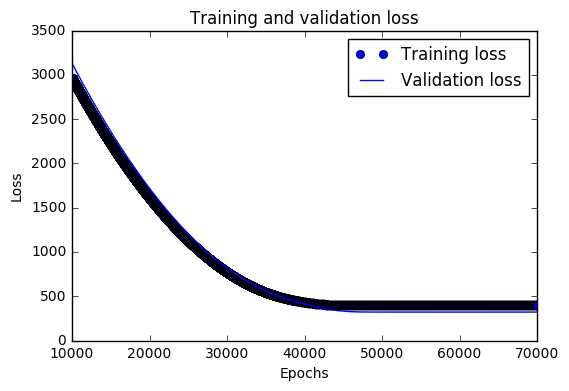

processing fold # 1
Thu Jan 25 11:45:03 2018
  Min error 167.443488 at epoch 69956
  CES ERROR:  52.36478715220493


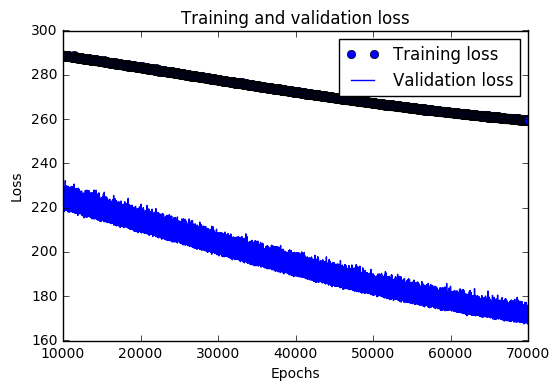

processing fold # 2
Thu Jan 25 12:15:09 2018
  Min error 111.856371 at epoch 57308
  CES ERROR:  77.93012315654695


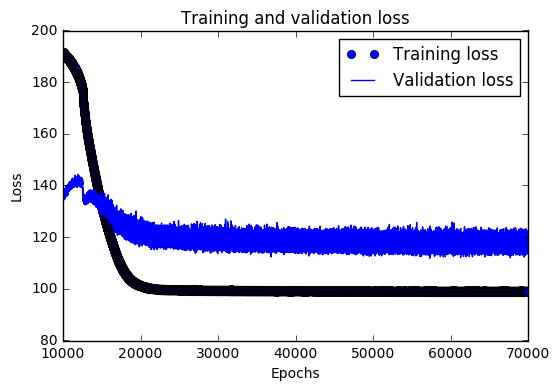

processing fold # 3
Thu Jan 25 12:38:36 2018
  Min error 280.467809 at epoch 55717
  CES ERROR:  24.221599304430242


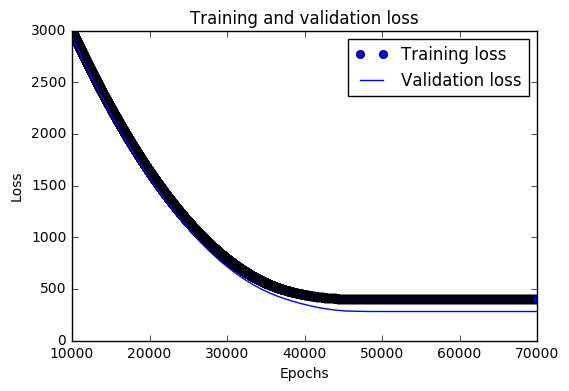

processing fold # 4
Thu Jan 25 13:01:36 2018
  Min error 580.283834 at epoch 4612
  CES ERROR:  23.352307156164937


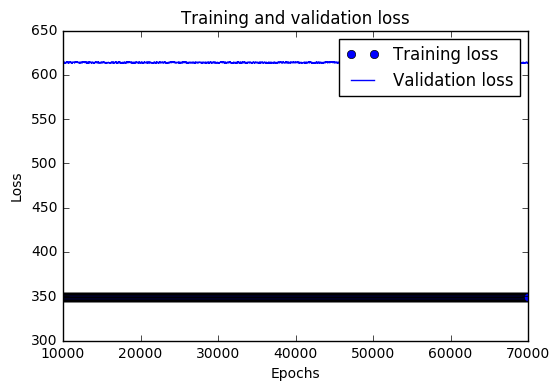

processing fold # 5
Thu Jan 25 13:25:08 2018
  Min error 286.620659 at epoch 59317
  CES ERROR:  24.153045495053973


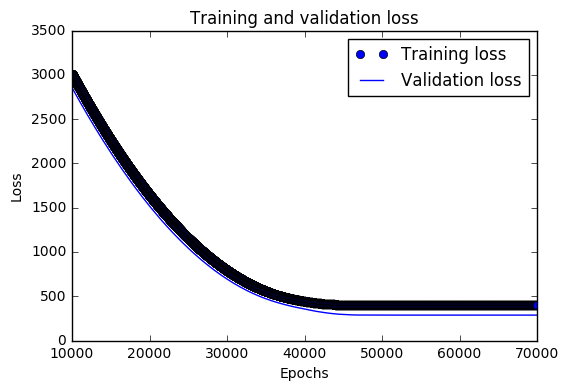

processing fold # 6
Thu Jan 25 13:47:54 2018
  Min error 447.562875 at epoch 10315
  CES ERROR:  42.0805492513192


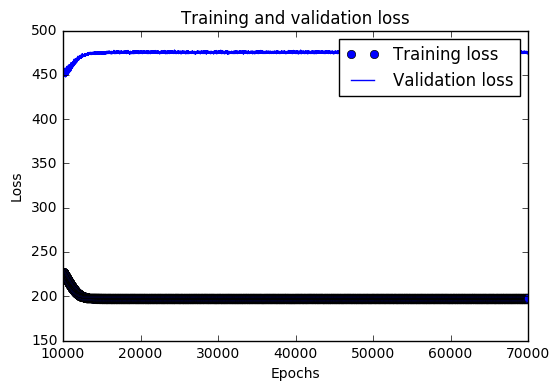

In [9]:
#################################################################################################
# K Fold Study
k = 7
n_samples = x_data.size // x_data.shape[1] // k
modelos = []

print(time.ctime())
print('Samples by fold: ', n_samples, '\n')
all_scores = []
all_hist = []
for i in range(k):
    print('processing fold #', i)

    x_valid_k = x_data[i * n_samples : (i + 1) * n_samples]
    y_valid_k = y_data[i * n_samples : (i + 1) * n_samples]
    x_data_k = np.concatenate([x_data[ : i * n_samples], x_data[(i + 1) * n_samples : ]], axis=0)
    y_data_k = np.concatenate([y_data[ : i * n_samples], y_data[(i + 1) * n_samples : ]], axis=0)

    modelos.append(build_model())
    hist_k = modelos[i].fit(x_data_k, y_data_k, validation_data=(x_valid_k, y_valid_k), epochs=epocas, batch_size=batch_size, verbose=0)
    #all_hist.append(hist3.history['val_loss'])
    y_predicted = modelos[i].predict(x_test)
    all_scores.append(calcError(y_test, y_predicted))
    all_hist.append(hist_k.history['val_mean_absolute_error'])
    print(time.ctime())
    print("  Min error %f at epoch %d" % (np.min(hist_k.history['val_loss'][:]), np.argmin(hist_k.history['val_loss'][:])))
    
    y_predicted = modelos[i].predict(x_test)
    print("  CES ERROR: ", calcError(y_test, y_predicted))
    
    grafica(hist_k)
beep()

In [10]:
y_predicted_tot = modelos[0].predict(x_test)
print("  CES ERROR ", 0, ": ", calcError(y_test, y_predicted_tot))
print(0, y_predicted_tot)
print()

for i in range(1, k):
    y = modelos[i].predict(x_test)
    y_predicted_tot += y
    print("  CES ERROR ", i, ": ", calcError(y_test, y))
    print(i, y)
    y_test0 = np.asarray(y_test)
    for x in range(1,10):
        print("---------------> Real vs Pred.: (%.0f, %.0f) vs (%.0f, %.0f)      err(%.1f, %.1f)"
              % (y_test0[x][0], y_test0[x][1], y[x][0], y[x][1],
                y_test0[x][0] - y[x][0], y_test0[x][1] - y[x][1]))
    print("\n")
    print()

print("  CES ERROR: ", calcError(y_test, y_predicted/k))
print(9, y_predicted_tot/k)
print('z', y_test)



  CES ERROR  0 :  24.265908814562845
0 [[72.441734 60.14927 ]
 [72.441734 60.14927 ]
 [72.441734 60.14927 ]
 ...
 [72.441734 60.14927 ]
 [72.50541  60.01093 ]
 [72.441734 60.14927 ]]

  CES ERROR  1 :  52.36478715220493
1 [[55.12829  15.139751]
 [55.80606  16.975107]
 [55.083538 15.018572]
 ...
 [54.04931  12.217976]
 [53.94763  11.942642]
 [57.671665 22.026995]]
---------------> Real vs Pred.: (81, 41) vs (56, 17)      err(25.5, 24.4)
---------------> Real vs Pred.: (73, 86) vs (55, 15)      err(17.5, 71.4)
---------------> Real vs Pred.: (67, 87) vs (54, 12)      err(13.2, 75.3)
---------------> Real vs Pred.: (81, 46) vs (55, 16)      err(25.9, 29.9)
---------------> Real vs Pred.: (47, 74) vs (62, 33)      err(-14.7, 40.3)
---------------> Real vs Pred.: (79, 68) vs (54, 13)      err(24.0, 54.5)
---------------> Real vs Pred.: (72, 45) vs (55, 16)      err(16.3, 28.6)
---------------> Real vs Pred.: (81, 67) vs (54, 13)      err(26.4, 53.4)
---------------> Real vs Pred.: (0, 0) vs

https://www.kaggle.com/

https://www.kaggle.com/op2501/wifi-fingerprint-location/editnb

